ValueError: At least 2 input points needed.

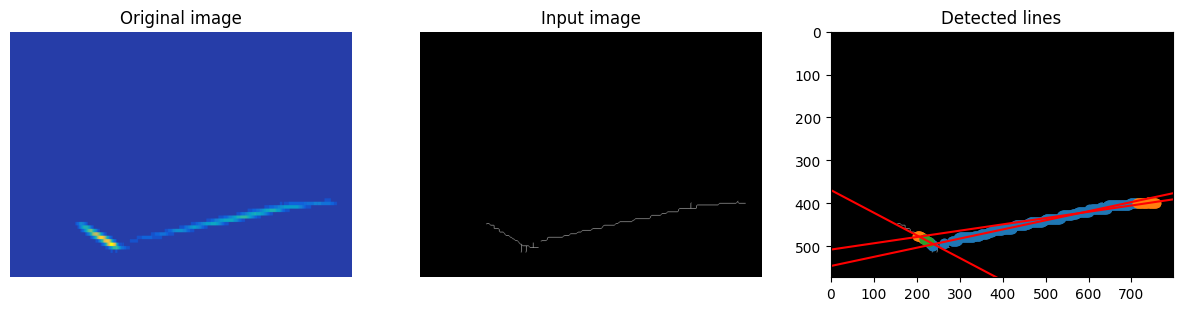

In [20]:
import sys
import os
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openImage import openImage
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from skimage.color import rgb2gray
from skimage.measure import LineModelND, ransac
from skimage.morphology import skeletonize



def processPixelSeries(series):

    middle_pixel = len(series) // 2
    series[middle_pixel:] = 0  # Set the right half to black
    half_width = len(series) // 2
    left_index = middle_pixel - half_width
    right_index = middle_pixel + half_width + 1
    series[right_index:] = 0  # Set the right half to black
    series[:left_index] = 0  # Set the left half to black

    return series

def processRow(row):

    # Find the indices where the consecutive series of 1s start and end
    starts = np.where(np.diff(np.concatenate(([0], row, [0]))) == 1)[0]
    ends = np.where(np.diff(np.concatenate(([0], row, [0]))) == -1)[0]

    # Iterate over the series and call the processPixelSeries function
    for start, end in zip(starts, ends):
        series = row[start:end]
        if len(series) > 4:
            row[start:end] = processPixelSeries(series)


        
    return row



def fitImage(path_and_name_input, path_and_name_output=None):

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    #Black and white
    test_image.m_data = rgb2gray(test_image.m_data)
    test_image.m_data = np.where(test_image.m_data < 0.3, 0, test_image.m_data)
    test_image.m_data = np.where(test_image.m_data >= 0.3, 1, test_image.m_data)


    #Thin the line
    """ for row in test_image.m_data:
        processRow(row) """
    
    #better version
    test_image.m_data = skeletonize(test_image.m_data)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image')
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Input image')
    ax[1].set_axis_off()

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_ylim((test_image.m_data.shape[0], 0))
    #ax[2].set_axis_off()
    ax[2].set_title('Detected lines')


    lines_eq=[]

    ransac_data = test_image.m_data

    points = np.argwhere(ransac_data == 1)[:, ::-1]

    min_samples = 70

    for i in range(10):

        if(len(points) < min_samples + 1):
            #print(f"\nStopped at iteration number {i}\n\n")
            break

        model, inliers = ransac(points, LineModelND, min_samples=min_samples, residual_threshold=5, random_state=0)

        outliers = inliers == False

        if(type(model) is type(None)):
            break

        ax[2].scatter(points[inliers][:, 0], points[inliers][:, 1]) 


        if(model.params[1][0] == 0):
            slope = 999 #temporary fix
        else:
            slope = model.params[1][1] / \
                model.params[1][0]
        intercept = model.params[0][1] - \
            slope * model.params[0][0]


        #print(f"Equation: y = {slope}*x+{intercept}")
        #print(f"Line from {model.params[0][0]}, {model.params[0][1]} to {model.params[1][0]}, {model.params[1][1]}")


        x = np.arange(0, test_image.m_data.shape[1])
        #x = np.arange(points[inliers][:, 0].min(), points[inliers][:, 0].max())
        y = slope * x + intercept


        ax[2].plot(x, y, label="fitted line", color='red')

        points = points[outliers]

        lines_eq.append([slope, intercept])


    intersections=[]

    for i, (slope1, intercept1) in enumerate(lines_eq):
        for slope2, intercept2 in lines_eq[i + 1:]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if(x>0 and x<800 and y>0 and y<600):
                    intersections.append((x, y))

    if(len(intersections) != 0):
        average_x = sum(map(lambda point: point[0], intersections)) / len(intersections)
        average_y = sum(map(lambda point: point[1], intersections)) / len(intersections)
        ax[2].plot(average_x, average_y, marker='o', markersize=10, color='red')
        ax[0].plot(average_x, average_y, marker='o', markersize=5, color='red')
        
    plt.tight_layout()
    #plt.show()
    plt.savefig(path_and_name_output)



#Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))
